In [1]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [4]:
# Main thread

if __name__ == '__main__':

    # Configuring paths and inputs -------------------------------------------------------------------------------------
    my_data = np.loadtxt('./../../Catalogue/binom_reg_dataset.csv', delimiter=',', dtype=str)

    my_dictionary = {}
    for i in range(len(my_data[0, :])):                                         # Converting numpy array into dictionary
         my_dictionary[my_data[0, i]] = np.array(my_data[0 + 1:, i], dtype=str)

    logit_class   = my_dictionary['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].astype(int)
    whan_class    = my_dictionary['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].astype(float)
    

    x     = whan_class
    y     = logit_class             # whether this is a galaxy with uv upturn or not
    n_obs = x.size

    regression_data = {}
    regression_data['K'] = 3      # number of betas
    regression_data['X'] = sm.add_constant(np.column_stack((x, x**2)))
    regression_data['N'] = n_obs
    regression_data['Y'] = y
    regression_data['LogN'] = np.log(n_obs)
    
    # Data to be plotted -------------------------------------------------------------------------------------------
    n_obs2 = 1500  
    x1 = np.linspace(x.min(), x.max(), n_obs2)
    
    regression_data['X2'] = sm.add_constant(np.column_stack((x1, x1**2)))
    regression_data['N2'] = n_obs2
    
    print n_obs
    print n_obs2
    print regression_data['X2'].shape
    

    # Fit: STAN code ---------------------------------------------------------------------------------------------------
    stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> N2;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        matrix[N2,K] X2;
        real LogN;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        vector[N2] etanew;
        real<lower=0, upper=1.0> pnew[N2];
        etanew = X2 * beta;
        for (j in 1:N2){
            pnew[j] = inv_logit(etanew[j]);
            /* LLi[j] = bernoulli_lpmf(1|pnew[j]); */
        }

    }
#     """

    fit = pystan.stan(model_code=stan_code, data=regression_data, iter=5000, chains=3, warmup=2000, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52d3b28c2232f31a9308d6e9b97c3201 NOW.


506
1500
(1500, 3)


In [5]:
lines = list(range(8)) + [2 * n_obs2 + 8, 2 * n_obs2 + 9, 2 * n_obs2 + 10]
output = str(fit).split('\n')
for i in lines:
    print(output[i])

Inference for Stan model: anon_model_52d3b28c2232f31a9308d6e9b97c3201.
3 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=9000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]       -0.68  4.8e-3   0.21  -1.09  -0.82  -0.68  -0.54  -0.29 1864.0    1.0
beta[1]        0.37  6.5e-3   0.27  -0.14   0.19   0.37   0.56   0.91 1719.0    1.0
beta[2]       -0.06  1.4e-3   0.06  -0.18   -0.1  -0.06  -0.02   0.05 1822.0    1.0
pnew[994]      0.47  7.6e-4   0.04   0.39   0.44   0.47   0.49   0.55 2880.0    1.0
pnew[995]      0.47  7.6e-4   0.04   0.39   0.44   0.47   0.49   0.55 2882.0    1.0
pnew[996]      0.47  7.6e-4   0.04   0.39   0.44   0.47   0.49   0.55 2883.0    1.0


In [6]:
print fit

Inference for Stan model: anon_model_52d3b28c2232f31a9308d6e9b97c3201.
3 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=9000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]       -0.68  4.8e-3   0.21  -1.09  -0.82  -0.68  -0.54  -0.29 1864.0    1.0
beta[1]        0.37  6.5e-3   0.27  -0.14   0.19   0.37   0.56   0.91 1719.0    1.0
beta[2]       -0.06  1.4e-3   0.06  -0.18   -0.1  -0.06  -0.02   0.05 1822.0    1.0
eta[0]        -0.19  1.8e-3   0.16  -0.52   -0.3  -0.19  -0.08   0.12 8220.0    1.0
eta[1]        -0.37  1.6e-3   0.12  -0.61  -0.45  -0.37  -0.29  -0.14 5697.0    1.0
eta[2]        -0.37  1.6e-3   0.12  -0.61  -0.45  -0.37  -0.29  -0.14 5697.0    1.0
eta[3]        -0.68  4.8e-3   0.21  -1.09  -0.82  -0.68  -0.54  -0.29 1864.0    1.0
eta[4]        -0.37  1.6e-3   0.12  -0.61  -0.45  -0.37  -0.29  -0.14 5697.0    1.0
eta[5]        -0.37  1.6e-3   0.12  -0.61  -0.45  -0.37

In [7]:
output = str(pystan.misc._print_stanfit(fit, digits_summary=4)).split('\n')

In [8]:
posteriors = list(fit.extract(u'beta').items()[0])

In [9]:
betas = posteriors[1]

In [10]:
print betas.shape

(9000, 3)


In [11]:
beta0 = betas[:,0]
beta1 = betas[:,1]
beta2 = betas[:,2]

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


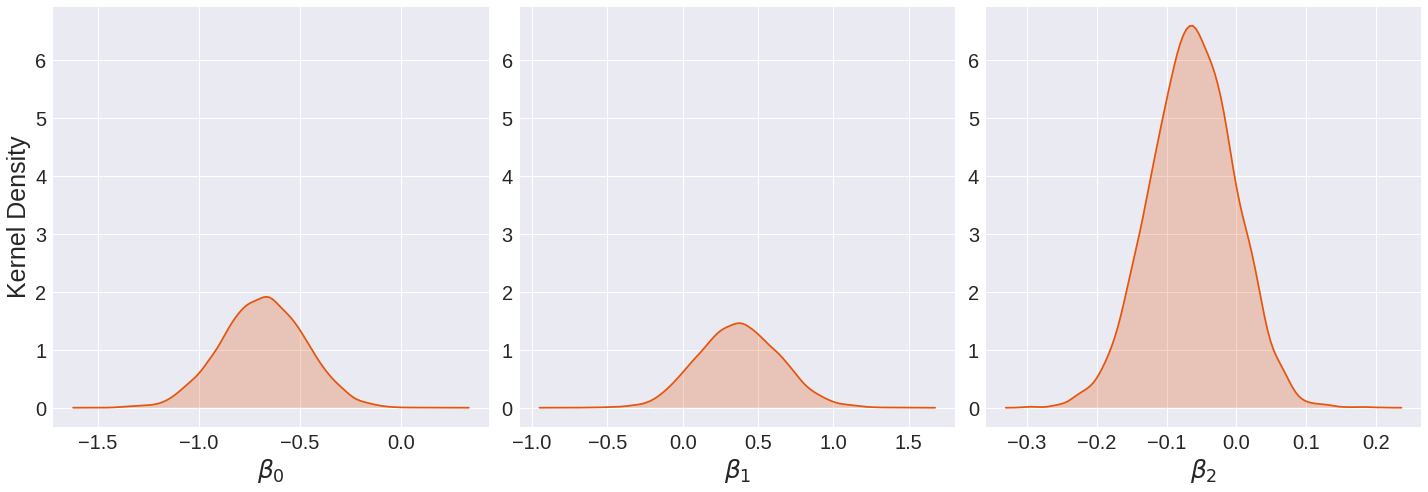

In [12]:
plt.subplots(1,1, figsize=(20,7), sharey=True)

plot01 = plt.subplot(1,3,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,3,2, sharey=plot01)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,3,3, sharey=plot01)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
plt.savefig('./../Model/Results/posterios_sharey_2d_teste.pdf', dpi=100)
plt.show()

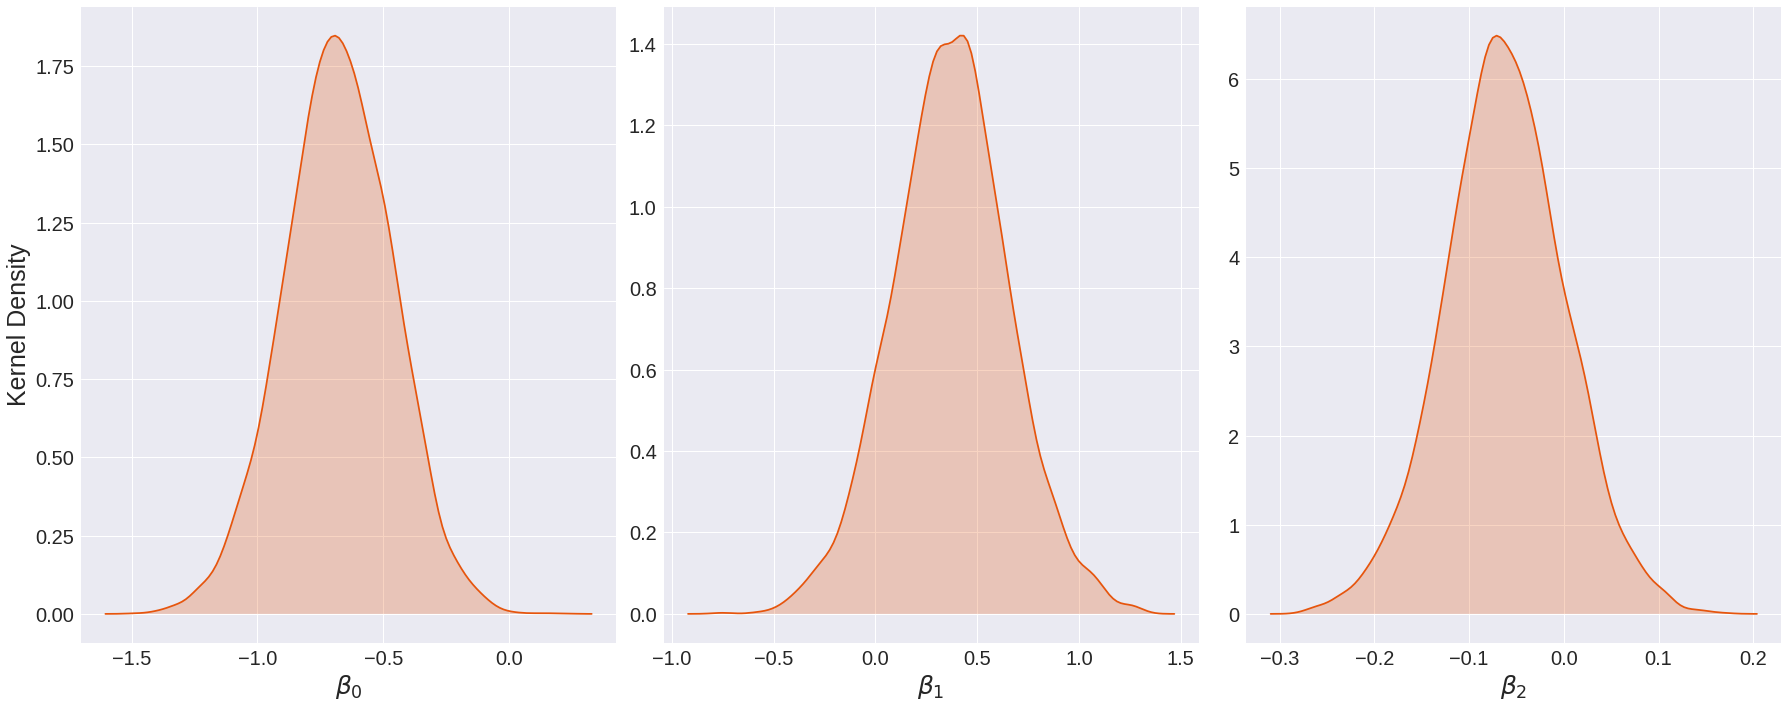

In [12]:
plt.subplots(1,1, figsize=(25,10), sharey=True)

plot01 = plt.subplot(1,3,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,3,2)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,3,3)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
plt.savefig('./../Model/Results/posterios_2d_teste.pdf', dpi=100)
plt.show()

In [13]:
output = np.array(output)

In [14]:
new_output = output[5:-6] #removing header and footer
print new_output.shape
print new_output.size
print new_output[0].split()[0]

(3509,)
3509
beta[0]


In [18]:
print new_output[-1]
print new_output[-2]
print new_output[2009].split()[1][0:6]
print new_output[2009].split()

pnew[1499]   0.4526  0.0004 0.0401 0.3729 0.4252 0.4531 0.4801 0.5303   8231 1.0004
pnew[1498]   0.4527  0.0004   0.04  0.373 0.4253 0.4532 0.4802 0.5302   8257 1.0004
0.3371
['pnew[0]', '0.3371', '0.0011', '0.0455', '0.2518', '0.3053', '0.3361', '0.3675', '0.4285', '1857', '1.0028']


In [19]:
diagnostics = []
for i in range(new_output.size):
    if len(new_output[i].split())<11:
        print i, len(new_output[i].split()),'\n'
        print new_output[i].split(), len(new_output[i].split())
        diagnostics.append(len(new_output[i].split()))
    else:
        continue
print np.unique(diagnostics)

[]


In [20]:
header_fit = output[4].split()
print header_fit

['mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [21]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', 'mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [22]:
new_data = header_fit
for i in range(new_output.size):
    if len(new_output[i].split())!=11: #the length of the list must be 11, in which case we connect them directly
        print "there is a problem!"
    else:
        new_output_i = np.array(new_output[i].split()).reshape(1,11)
        new_data = np.vstack((new_data, new_output_i))       

In [23]:
import pandas as pd

In [24]:
new_dataframe = pd.DataFrame(new_data)
new_dataframe.to_csv('./Results/fit_results_2d_teste.csv', sep=',', header=False, index=False)

In [25]:
print new_data.shape
print new_data[-1]

(3510, 11)
['pnew[1499]' '0.4526' '0.0004' '0.0401' '0.3729' '0.4252' '0.4531'
 '0.4801' '0.5303' '8231' '1.0004']


In [26]:
betas = {}
betas['beta0'] = beta0
betas['beta1'] = beta1
betas['beta2'] = beta2

In [27]:
betas_dataframe = pd.DataFrame(betas)
betas_dataframe.to_csv('./Results/betas_2d_teste.csv', sep=',', header=True, index=False)

In [28]:
pnew = list(fit.extract(u'pnew').items()[0])

In [40]:
len(pnew[1])

9000

In [33]:
model_results = {}
model_results['pnew']       = pnew[1][0]
model_results['whan_class'] = x1

In [34]:
print model_results['pnew'].shape
print x1.shape

(1500,)
(1500,)


In [35]:
model_dataframe = pd.DataFrame(model_results)
model_dataframe.to_csv('./Results/model_prob_2d_teste.csv', sep=',', header=True, index=False)